https://accelconf.web.cern.ch/e04/PAPERS/THPKF005.PDF

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5929359/

https://inis.iaea.org/collection/NCLCollectionStore/_Public/36/041/36041296.pdf?r=1&r=1

https://www.ph.unimelb.edu.au/~djpeake/djp_thesis.pdf

https://inis.iaea.org/collection/NCLCollectionStore/_Public/33/034/33034307.pdf?r=1&r=1

https://accelconf.web.cern.ch/e08/papers/tupc010.pdf  single bunch current up to 10 mA

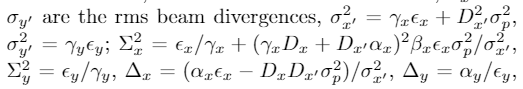

In [1]:
import numpy as np

In [2]:
np.sqrt(16e-9*9.469)*1e6

389.2351474366106

In [3]:
np.sqrt(16e-9*0.01*2.462)*1e6

19.847417968088447

In [15]:
Ku = 1.75
lamu = 22e-3
gamma = 3e9/0.511e6
lam1 = lamu/2/gamma**2*(1+Ku**2/2)
ex = 16e-9 # m
kappa = 0.01
ey = kappa*ex
# betax, betay = 
sx = 387e-6
sy = 20e-6
bx = sx**2/ex
by = sy**2/ey
sxp = 41e-6
syp = 8e-6
gx = sxp**2/ex
gy = syp**2/ey
sz = 9.84e-3
Nu = 3.0/lamu
skrel = 0.1/Nu
sk = skrel*2*np.pi/lam1
sl = skrel*lam1
Ml = 2*sk*sz
T = 216/3e8
Imax = 10e-3
Ne = Imax*T/1.6e-19
avN = np.pi/2*1/137*Nu*Ne*skrel*np.sqrt(2*np.pi)
usx = 1/gamma*np.sqrt((1+Ku**2/2)/Nu)
usy = usx
k0 = 2*np.pi/lam1
M = np.sqrt(
    (1+4*sk**2*sz**2)
    * (1+4*k0**2*sx**2*(sxp**2+usx**2)+sxp**2/usx**2)
    * (1+4*k0**2*sy**2*(syp**2+usy**2)+syp**2/usy**2)
)
Ne, Ml, avN, usx, M, lam1*1e6, k0*sx*usx, k0*sy*usy, k0*sx*sxp, k0*sy*syp, sxp, usx, 8*sk*sz*k0**2*sxp*syp*usx*usy, lam1

(45000000000.0,
 112248.19653069638,
 129330738.60538483,
 2.3206939964157275e-05,
 245447145.0889269,
 0.00080784309375,
 69.85245843510758,
 3.609946172356982,
 123.40923879937357,
 1.2444367686329978,
 4.1e-05,
 2.3206939964157275e-05,
 4797938.403702098,
 8.0784309375e-10)

In [5]:
import sys

from wigrad import Wiggler, WigglerRadiationSimulator

import scipy.signal
from scipy.optimize import minimize
import pandas as pd
pd.set_option('max_columns', None)
from sklearn import linear_model
import matplotlib.pyplot as plt
from datetime import datetime
plt.rcParams['figure.figsize'] = [15, 7.5]
plt.rcParams.update({'font.size': 16,'legend.fontsize':16})
import seaborn as sns
import sys
import os
import fur.path_assistant as path_assistant
from fur.waveform_reader import read_waveform
from fur.finding_period import get_period
from fur.fluctuations import get_fluctiation_and_noise_var
from fur.one_data_set_analyzer import analyze_one_dataset
from fur.extending_with_acnet_data import get_fluctuations_df_with_acnet_data, get_acnet_df_with_bunch_sizes
shift = path_assistant.PathAssistant('shift_03_16_2020',
    ignore_files=['RefCurve_2020-03-16_0_084020_test.Wfm.bin',
                  'RefCurve_2020-03-16_153_155200.Wfm.bin'])
#shift_03_09_2020.show_waveform_file_names()
waveforms_dir = shift.get_waveforms_dir()
results_dir = shift.get_results_dir()
from config import get_from_config, save_to_config
from wiggler_radiation.number_of_coherent_modes.coherent_modes import get_M_interpolator_at_fixed_energy
import lattice.lattice as lattice
from lattice.summary_in_undulator import CalcTransverseBeamParams
from wiggler_radiation.Wigrad.wigrad_generator import \
    generate_wr_sim_with_wigrad_results_and_spectral_transmission
import coherent_modes_cpp as cm



m0 = 10000
mfold = 11
seed = 1


wiggler = Wiggler(K_peak=Ku, N_periods=Nu, lambda_wiggler_m=lamu)
xmax = 3*1/gamma/np.sqrt(Nu)  # rad
ymax = xmax  # rad
n_x = 400  # after using symmetries the size will be twice that
n_y = 400  # after using symmetries the size will be twice that
n_l = 100
lmin = (lam1-3*sl)*1e6  # um
lmax = (lam1+3*sl)*1e6  # um
x_step = xmax/(n_x-1)
y_step = ymax/(n_y-1)
l_step = (lmax-lmin)/(n_l-1)
# this mesh is only for positive theta_x and theta_y, the results will be extended later using symmetries (two mirror symmetries: along y-axis and along x-axis)
mesh = (np.linspace(x_step/2, xmax, n_x),
        np.linspace(y_step/2, ymax, n_y),
        np.linspace(lmin, lmax, n_l))

spect = np.exp(-1/2/(sl*1e6)**2*(np.linspace(lmin, lmax, n_l)-lam1*1e6)**2)

wr_sim = WigglerRadiationSimulator(
    wiggler,
    mesh,
    gamma=gamma,
    harmonics=[1],  # harmonics to be calculated have to be specified
    aperture=None,  # as of now the only other option is 'ellipse'
    spectral_transmission=None  # you can provide transmission of filters, QE of detector here, 1D array of the same length as the wavelengths array
    )

wr_sim.calc_amplitude_on_meshgrid()

wr_sim.extend_results_using_symmetries()

ampx3d = wr_sim.get_amplittude_3D(polarization='x')

xmin = -xmax
ymin = -ymax

dax = x_step
day = y_step
dl = l_step
elliptic_aperture = \
        (wr_sim.x_3D**2/xmax**2+wr_sim.y_3D**2/ymax**2) < 1
sm =dax*day*dl*np.sum(
    spect[:,None,None]*np.absolute(ampx3d*elliptic_aperture)**2)


# In[13]:


st = sz*1e6
Sx, Sy, dx, dy, sxp, syp = sx*1e6, sy*1e6, 0, 0, sxp, syp
coh_modes_cpp_args =  np.asarray([Sx,Sy,dx,dy,sxp,syp,xmin,xmax,ymin,ymax,lmin,lmax,
                                  st, sm, m0,mfold,seed],
                                dtype=np.float64)
Mi = np.real(
    cm.CalcMFromPrecalculatedFieldAmps(ampx3d,spect,coh_modes_cpp_args)[-1])
print(Mi)

122562527.8706511


In [6]:
sm*Ne

102769716.91446504

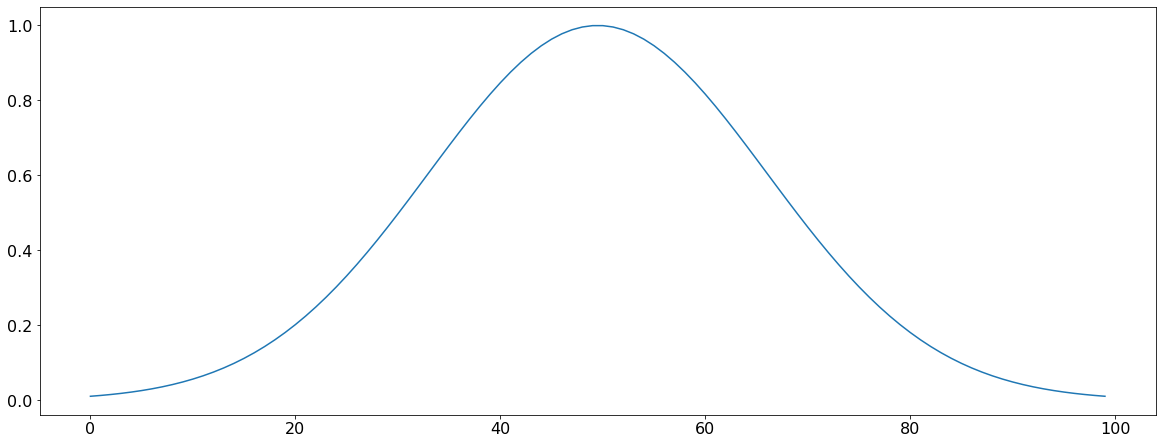

In [7]:
plt.plot(spect)

In [12]:
print(f"{Ne:.1e}")

4.5e+10


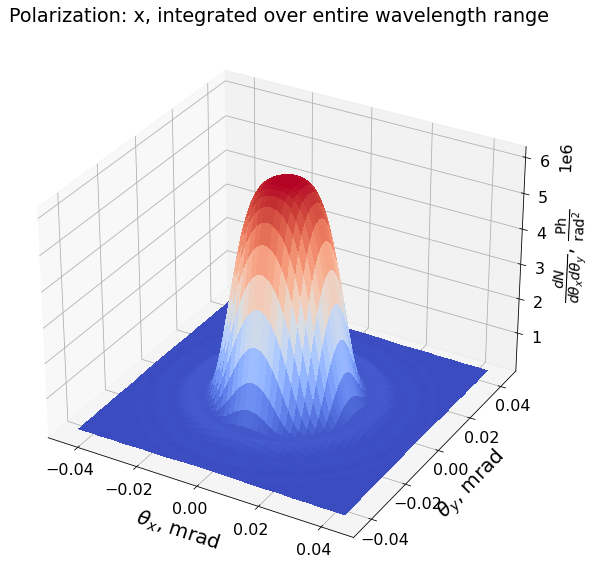

In [9]:
wr_sim.show_angular_distribution(polarization='x')

In [10]:
mesh

(array([5.48363730e-08, 1.64371684e-07, 2.73906996e-07, 3.83442307e-07,
        4.92977619e-07, 6.02512930e-07, 7.12048242e-07, 8.21583553e-07,
        9.31118865e-07, 1.04065418e-06, 1.15018949e-06, 1.25972480e-06,
        1.36926011e-06, 1.47879542e-06, 1.58833073e-06, 1.69786605e-06,
        1.80740136e-06, 1.91693667e-06, 2.02647198e-06, 2.13600729e-06,
        2.24554260e-06, 2.35507791e-06, 2.46461323e-06, 2.57414854e-06,
        2.68368385e-06, 2.79321916e-06, 2.90275447e-06, 3.01228978e-06,
        3.12182509e-06, 3.23136041e-06, 3.34089572e-06, 3.45043103e-06,
        3.55996634e-06, 3.66950165e-06, 3.77903696e-06, 3.88857227e-06,
        3.99810759e-06, 4.10764290e-06, 4.21717821e-06, 4.32671352e-06,
        4.43624883e-06, 4.54578414e-06, 4.65531945e-06, 4.76485477e-06,
        4.87439008e-06, 4.98392539e-06, 5.09346070e-06, 5.20299601e-06,
        5.31253132e-06, 5.42206664e-06, 5.53160195e-06, 5.64113726e-06,
        5.75067257e-06, 5.86020788e-06, 5.96974319e-06, 6.079278